# Implementing a custom fitter

For when fit_lc() won't cut it.

In [1]:
from __future__ import print_function

import os

import numpy as np
import sncosmo
import matplotlib as mpl

%matplotlib inline

mpl.rc('savefig', dpi=110.)

In [2]:
# we're going to use an optimizer from scipy
from scipy.optimize import fmin_l_bfgs_b

In [3]:
model = sncosmo.Model(source='salt2')
data = sncosmo.read_lc('data/lc-SDSS19230.list', format='salt2')
print(data)

   Date     Flux  Fluxerr  ZP   Filter MagSys
--------- ------- ------- ---- ------- ------
54346.219   22.71  21.718 27.5 SDSS::g AB_B12
54346.219   -2.46  27.534 27.5 SDSS::r AB_B12
54346.219   20.46  41.593 27.5 SDSS::i AB_B12
54346.219 -115.03 125.221 27.5 SDSS::z AB_B12
54346.219   -28.6  51.474 27.5 SDSS::u AB_B12
54356.262     4.5  16.025 27.5 SDSS::g AB_B12
54356.262   26.08  24.989 27.5 SDSS::r AB_B12
54356.262  -46.38  38.447 27.5 SDSS::i AB_B12
54356.262   73.92 111.835 27.5 SDSS::z AB_B12
54356.262   45.81    47.5 27.5 SDSS::u AB_B12
      ...     ...     ...  ...     ...    ...
54425.156  233.95 130.631 27.5 SDSS::z AB_B12
54425.156  102.74 117.493 27.5 SDSS::u AB_B12
54431.164   -62.6  57.574 27.5 SDSS::g AB_B12
54431.164   37.82  53.102 27.5 SDSS::r AB_B12
54431.164   85.49  68.862 27.5 SDSS::i AB_B12
54431.164   68.32 173.411 27.5 SDSS::z AB_B12
 54433.16  -10.43  18.376 27.5 SDSS::g AB_B12
 54433.16   91.96  33.672 27.5 SDSS::r AB_B12
 54433.16  149.92  49.542 27.5 SDS

In [4]:
model.set(z=data.meta['Z_HELIO'])

In [5]:
# Define an objective function that we will pass to the minimizer.
# The function arguments must comply with the expectations of the specfic
# minimizer you are using.

def objective(parameters, model, data):
    model.parameters[1:5] = parameters
    
    # evaluate model fluxes at times/bandpasses of data
    model_flux = model.bandflux(data['Filter'], data['Date'],
                                zp=data['ZP'], zpsys=data['MagSys'])

    # calculate and return chi^2
    return np.sum(((data['Flux'] - model_flux) / data['Fluxerr'])**2)

In [6]:
# starting parameter values in same order as `model.param_names`:
start_parameters = [54400., 1e-5, 0., 0.]  # t0, x0, x1, c

# parameter bounds in same order as `model.param_names`:
bounds = [(54356., 54433.), (None, None), (-3., 3), (-0.3, 0.3)]

parameters, val, info = fmin_l_bfgs_b(objective, start_parameters, args=(model, data),
                                      bounds=bounds, approx_grad=True)

In [7]:
print(parameters)

[  5.43904929e+04   4.93486325e-05  -1.78237308e+00   8.44826264e-02]


In [8]:
print(val)

87.7752568476


In [9]:
print(info)

{'nit': 36, 'grad': array([  6.47872866e-03,   6.49762424e+02,   1.23776545e-03,
        -6.36148911e-02]), 'task': b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH', 'funcalls': 305, 'warnflag': 0}


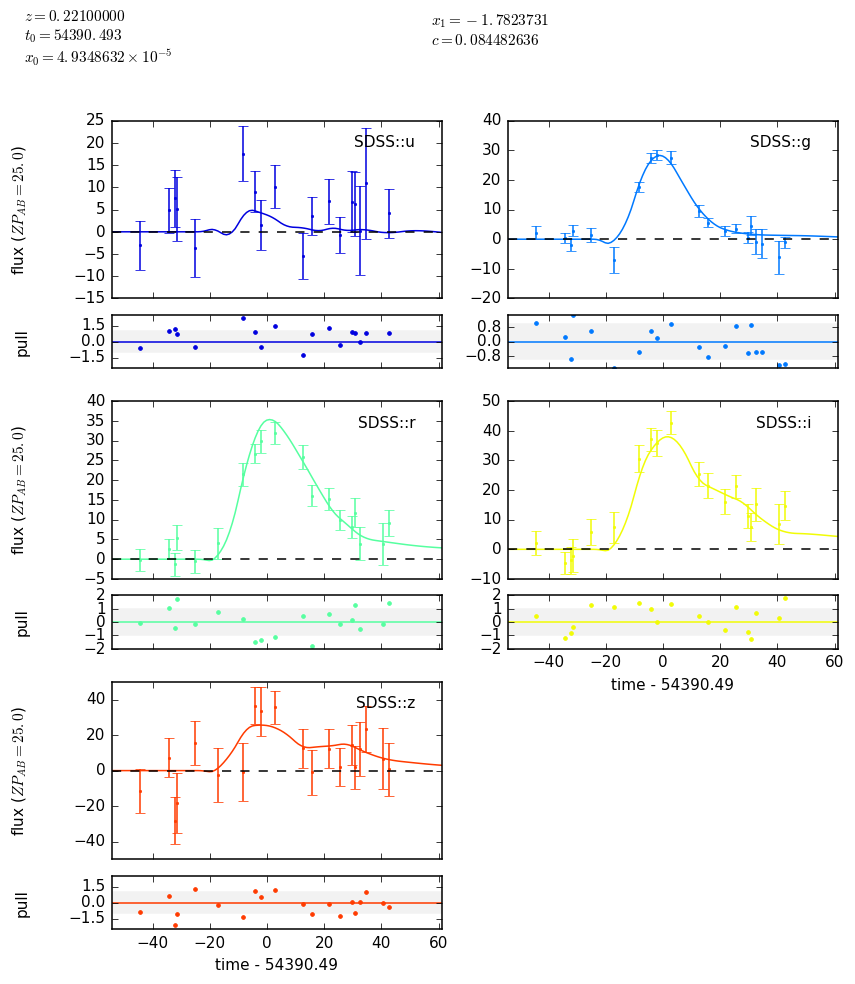

In [10]:
# plot it
sncosmo.plot_lc(data, model);